#1) GLM and Control Models

In [ ]:
#!pip install optuna #this is for parameter search
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

##a) Prepare Features and Targets for GLM
Flatten the 'action_sequences' and 'board_states' columns so that each row corresponds to a single action and its corresponding board state. split rows *before* flattening so that we dont split in the middle of someones sequence

In [ ]:
# Define the function to add steps-from-start and steps-from-end, this will be used during sequence processing later
def add_positions_and_reversed(df):
    df = df.copy()
    df['positions'] = df['action_sequences'].apply(lambda x: list(range(len(x))))
    df['reversed_positions'] = df['action_sequences'].apply(lambda x: list(range(len(x) - 1, -1, -1))) #(starting point of range, stopping point, step of range)
    return df

# Add positions and reversed positions to our DataFrame
final_df = add_positions_and_reversed(final_df)

# Separate the four columns for features, targets, positions, and reversed positions
Cont_X = final_df['board_states']
Cont_y = final_df['action_sequences']
Cont_positions = final_df['positions'] #will be used in sequence tracking later
Cont_reversed_positions = final_df['reversed_positions'] #will be used in sequence tracking later

# Split the data into training and validation sets (80/20 split)
Cont_X_train, Cont_X_val, Cont_y_train, Cont_y_val, positions_train, positions_val, reversed_positions_train, reversed_positions_val = train_test_split(
    Cont_X, Cont_y, Cont_positions, Cont_reversed_positions, test_size=0.2, random_state=42
)

# Flatten the training and validation data
flattened_board_states_train = np.concatenate(Cont_X_train.values)
flattened_action_sequences_train = np.concatenate(Cont_y_train.values)
flattened_positions_train = np.concatenate(positions_train.values)
flattened_reversed_positions_train = np.concatenate(reversed_positions_train.values)

flattened_board_states_val = np.concatenate(Cont_X_val.values)
flattened_action_sequences_val = np.concatenate(Cont_y_val.values)
flattened_positions_val = np.concatenate(positions_val.values)
flattened_reversed_positions_val = np.concatenate(reversed_positions_val.values)

# Convert flattened data to NumPy arrays
Cont_X_train = np.array(flattened_board_states_train, dtype=np.float32)
Cont_y_train = np.array(flattened_action_sequences_train, dtype=np.int32)
positions_train = np.array(flattened_positions_train, dtype=np.int32)
reversed_positions_train = np.array(flattened_reversed_positions_train, dtype=np.int32)

Cont_X_val = np.array(flattened_board_states_val, dtype=np.float32)
Cont_y_val = np.array(flattened_action_sequences_val, dtype=np.int32)
positions_val = np.array(flattened_positions_val, dtype=np.int32)
reversed_positions_val = np.array(flattened_reversed_positions_val, dtype=np.int32)

# Verify shapes
print("Shape of training board_states:", Cont_X_train.shape)
print("Shape of training action_sequences:", Cont_y_train.shape)
print("Shape of training positions:", positions_train.shape)
print("Shape of training reversed positions:", reversed_positions_train.shape)
print("Shape of validation board_states:", Cont_X_val.shape)
print("Shape of validation action_sequences:", Cont_y_val.shape)
print("Shape of validation positions:", positions_val.shape)
print("Shape of validation reversed positions:", reversed_positions_val.shape)


Shape of training board_states: (164038, 85)
Shape of training action_sequences: (164038,)
Shape of training positions: (164038,)
Shape of training reversed positions: (164038,)
Shape of validation board_states: (39411, 85)
Shape of validation action_sequences: (39411,)
Shape of validation positions: (39411,)
Shape of validation reversed positions: (39411,)


##b) GLM - Dense network with no hidden layers and softmax output

###i) Define and Fit Model

In [ ]:
# Determine the number of unique actions for the output layer size
num_actions = 12 #same as len(np.unique(Cont_y))

glm_model = Sequential([
    Dense(num_actions, input_shape=(85,), activation='softmax')
])

# Define the optimizer with a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile model
glm_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Add early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [ ]:
# Fit the model with early stopping
glm_history = glm_model.fit(
    Cont_X_train, Cont_y_train,
    epochs=50,
    validation_data=(Cont_X_val, Cont_y_val),
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.3902 - loss: 2.2202 - val_accuracy: 0.5603 - val_loss: 1.6523
Epoch 2/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.5798 - loss: 1.5361 - val_accuracy: 0.5798 - val_loss: 1.3994
Epoch 3/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.5959 - loss: 1.3456 - val_accuracy: 0.6278 - val_loss: 1.3226
Epoch 4/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.6351 - loss: 1.2854 - val_accuracy: 0.6355 - val_loss: 1.2877
Epoch 5/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.6431 - loss: 1.2575 - val_accuracy: 0.6419 - val_loss: 1.2682
Epoch 6/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.6454 - loss: 1.2387 - val_accuracy: 0.6433 - val_loss: 1.2559
Epoch 7/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.6480 - loss: 1.2302 - val_accuracy: 0.6438 - val_loss: 1.2474
Epoch 8/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6480 - loss: 1

###ii) Evaluate the model

####Training and Validation Loss and Accruacy

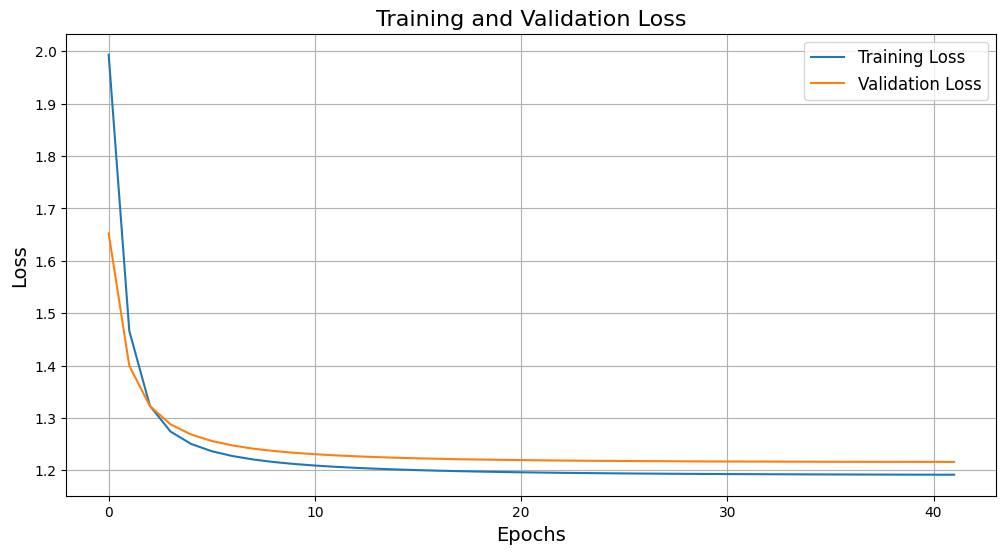

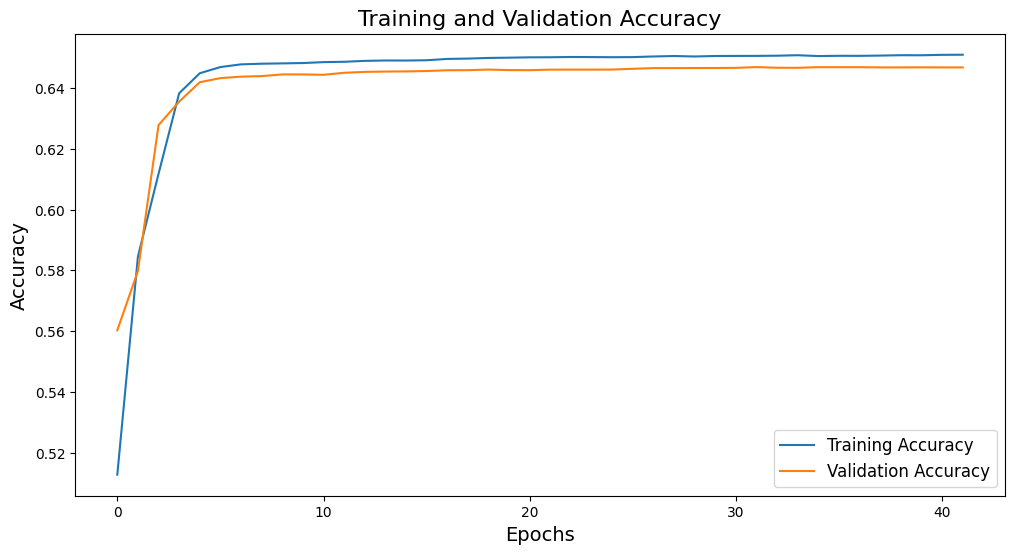

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(glm_history.history['loss'], label='Training Loss')
plt.plot(glm_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(glm_history.history['accuracy'], label='Training Accuracy')
plt.plot(glm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.show()


In [ ]:
Cont_val_loss, Cont_val_acc = glm_model.evaluate(Cont_X_val, Cont_y_val)
print(f'Validation Loss: {Cont_val_loss}')
print(f'Validation Accuracy: {Cont_val_acc}')

1232/1232 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6616 - loss: 1.1717
Validation Loss: 1.216591477394104
Validation Accuracy: 0.6469005942344666


####Visualize Weights

In [ ]:
# Extract the weights of the dense layer
Cont_weights, Cont_biases = glm_model.layers[0].get_weights()

Weights for all actions (Last 13 weights)

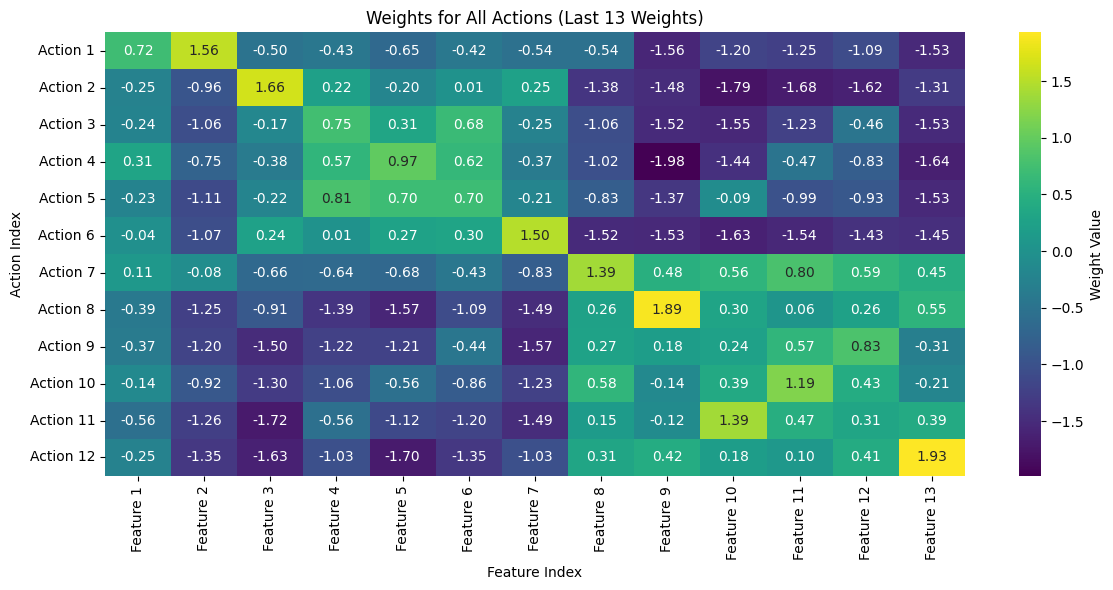

In [ ]:
import seaborn as sns

num_actions = 12
# Number of features to use (last 13)
num_features = 13

# Prepare an array to hold the last 13 weights for each action
weights_matrix = np.zeros((num_actions, num_features))

# Extract the last 13 weights for each action
for i in range(num_actions):
    weights_for_action = Cont_weights[-num_features:, i]  # Use negative indexing to get the last 13 weights
    weights_matrix[i] = weights_for_action

plt.figure(figsize=(12, 6))
sns.heatmap(weights_matrix, cmap='viridis', annot=True, fmt='.2f', cbar=True,
            cbar_kws={'label': 'Weight Value'},
            xticklabels=[f'Feature {j + 1}' for j in range(num_features)],
            yticklabels=[f'Action {i + 1}' for i in range(num_actions)])
plt.title('Weights for All Actions (Last 13 Weights)')
plt.xlabel('Feature Index')
plt.ylabel('Action Index')
plt.tight_layout()
plt.show()

Weights for boardstates (first 72 weights)

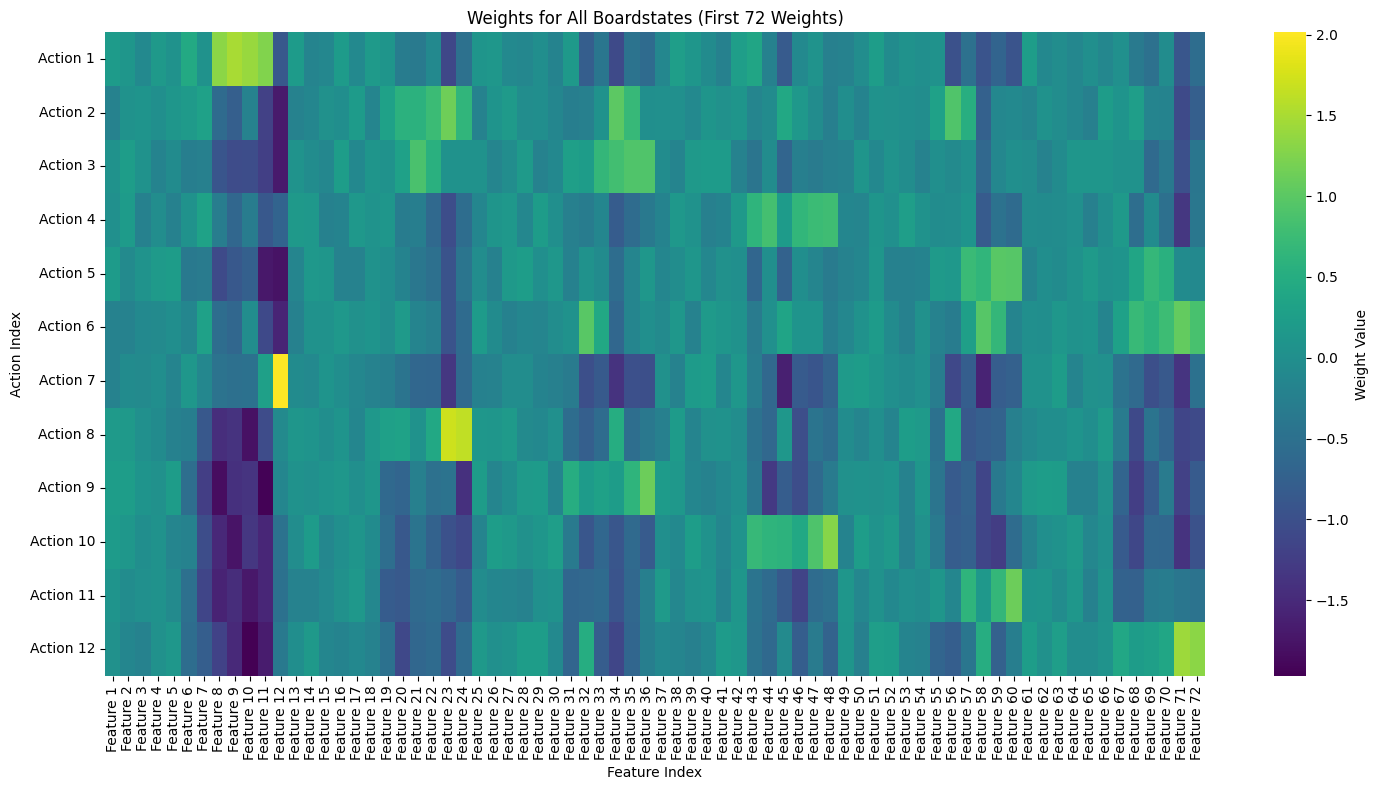

In [ ]:
# Number of features to use (first 72)
num_features = 72

# Prepare an array to hold the first 72 weights for each Boardstate
weights_matrix = np.zeros((num_actions, num_features))

# Extract the first 72 weights for each action
for i in range(num_actions):
    weights_for_action = Cont_weights[:num_features, i]  # Using slicing to get the first 72 weights
    weights_matrix[i] = weights_for_action

plt.figure(figsize=(15, 8))
sns.heatmap(weights_matrix, cmap='viridis', cbar=True,
            cbar_kws={'label': 'Weight Value'},
            xticklabels=[f'Feature {j + 1}' for j in range(num_features)],
            yticklabels=[f'Action {i + 1}' for i in range(num_actions)])
plt.title('Weights for All Boardstates (First 72 Weights)')
plt.xlabel('Feature Index')
plt.ylabel('Action Index')
plt.tight_layout()
plt.show()

visualize the weights for each of the 12 actions individually


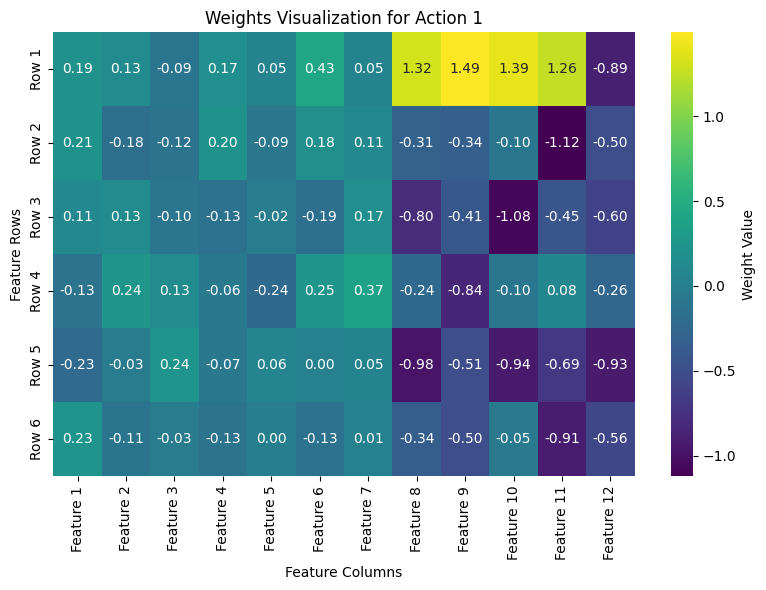

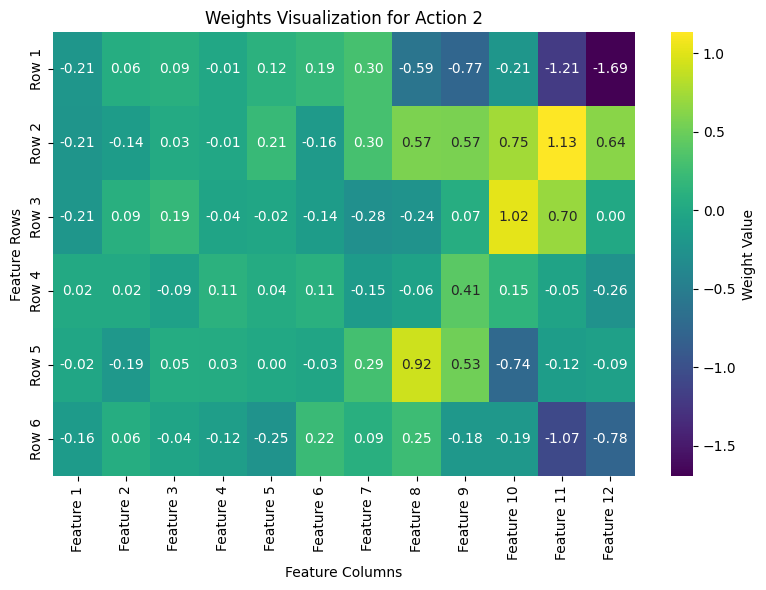

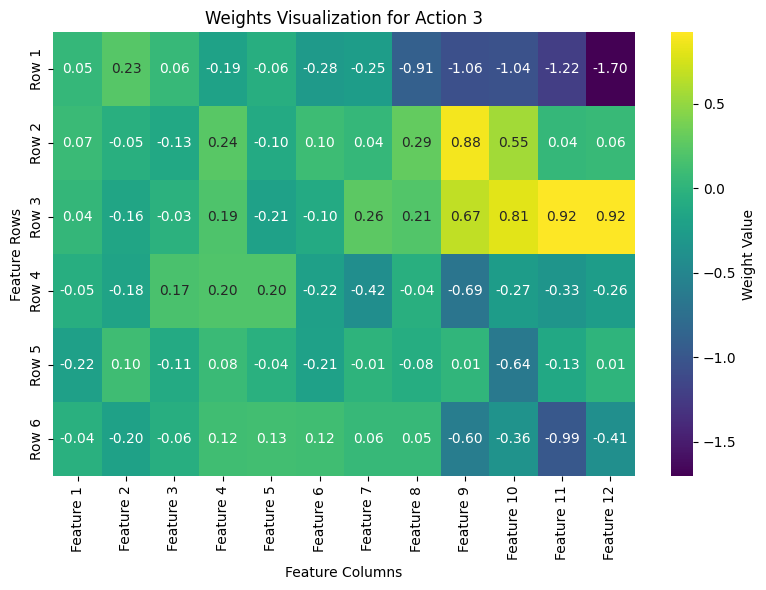

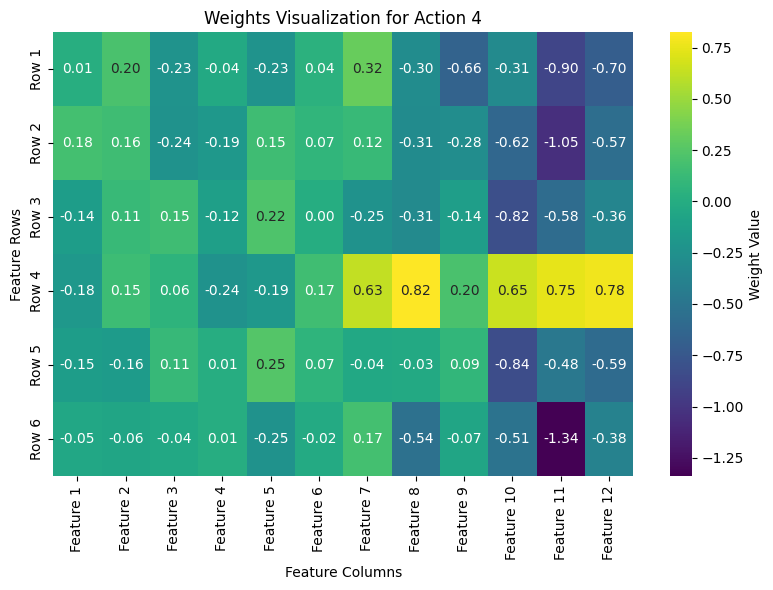

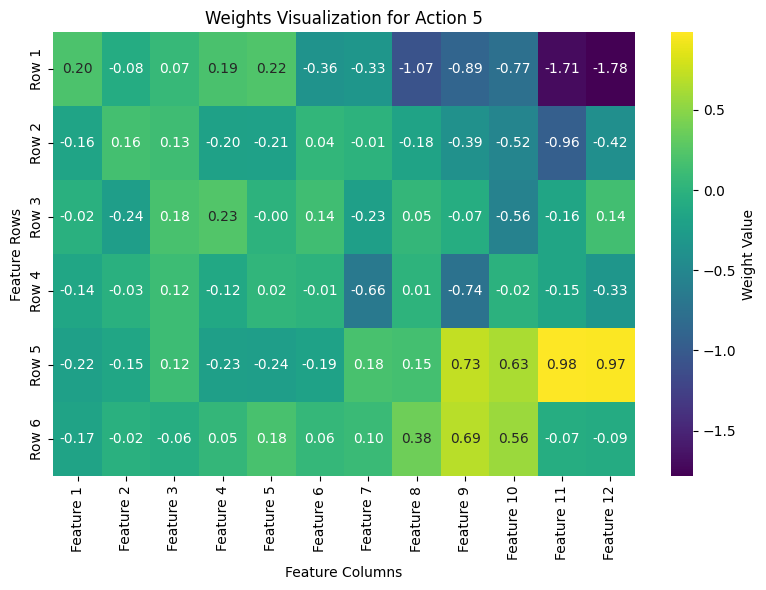

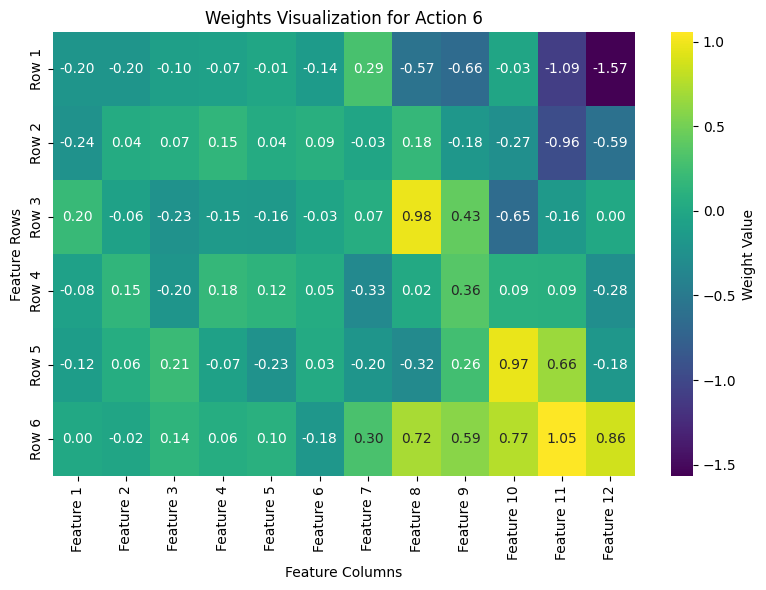

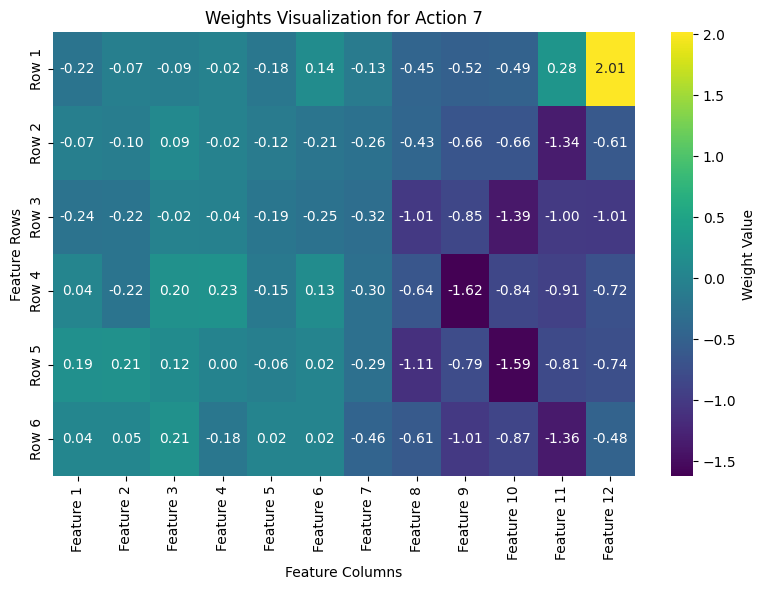

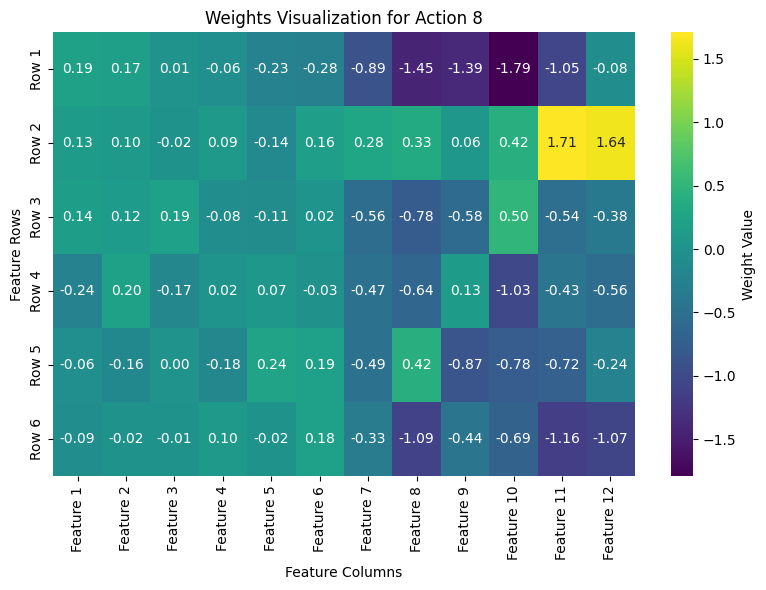

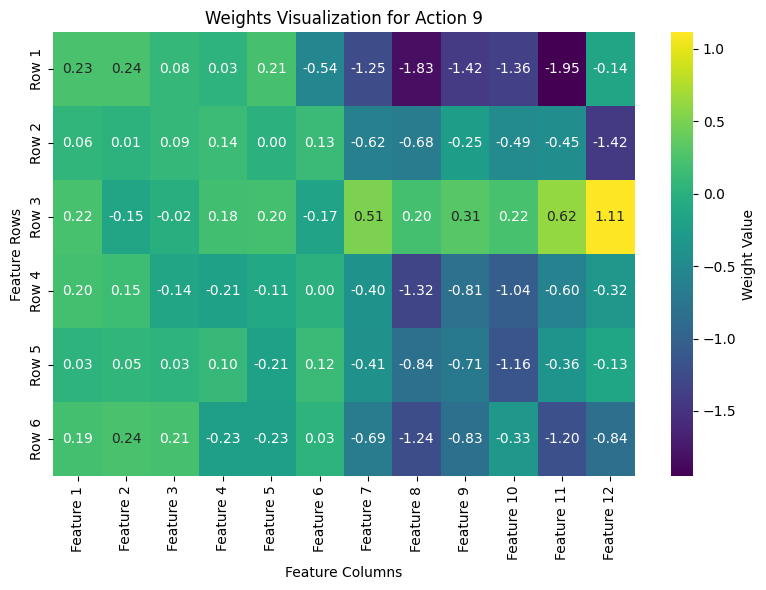

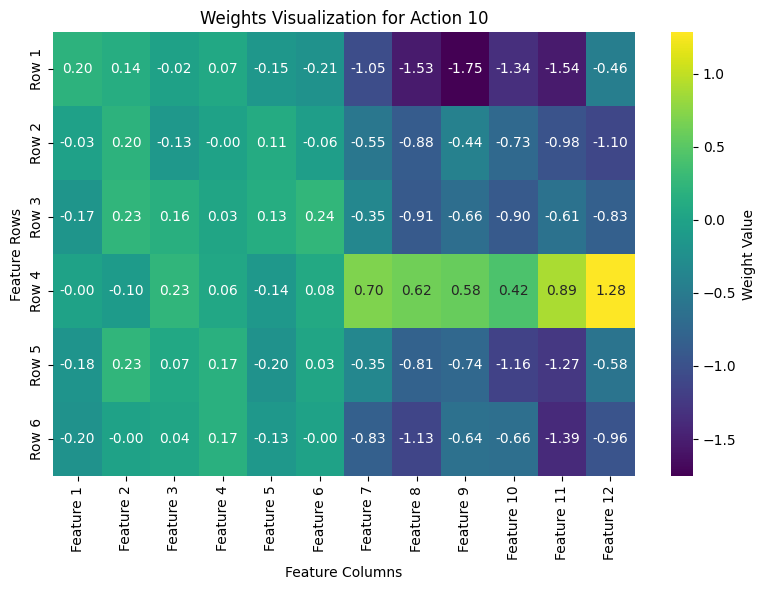

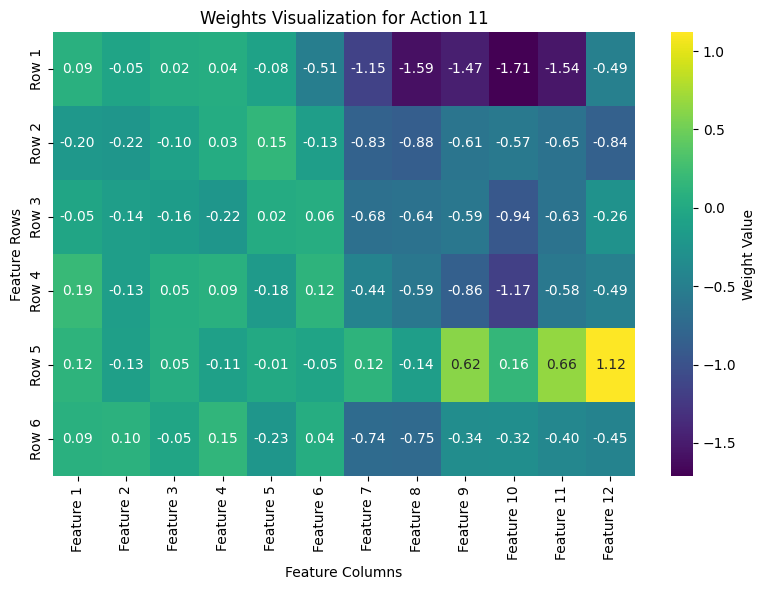

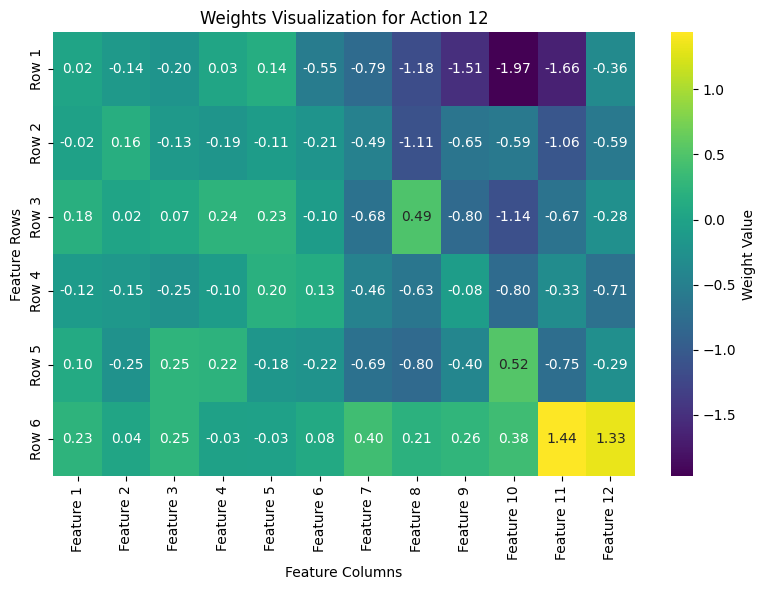

In [ ]:
#visualize the weights for each of the 12 actions individually

# Parameters for visualization
num_actions = 12  # Number of actions
num_features = 72  # First 72 weights
rows, cols = 6, 12  # Reshaping parameters

# Extract and reshape weights
reshaped_weights = []
for i in range(num_actions):
    # Extract the first 72 weights for each action and reshape to 6x12
    weights_for_action = Cont_weights[:num_features, i]
    reshaped_weights.append(weights_for_action.reshape(rows, cols))

# Plotting with sns.heatmap and annot=True
for i, weights in enumerate(reshaped_weights):
    plt.figure(figsize=(8, 6))
    sns.heatmap(weights, cmap='viridis', annot=True, fmt='.2f', cbar=True,
                cbar_kws={'label': 'Weight Value'},
                xticklabels=[f'Feature {j + 1}' for j in range(cols)],
                yticklabels=[f'Row {j + 1}' for j in range(rows)])
    plt.title(f'Weights Visualization for Action {i + 1}')
    plt.xlabel('Feature Columns')
    plt.ylabel('Feature Rows')
    plt.tight_layout()
    plt.show()

####Visualize Bias

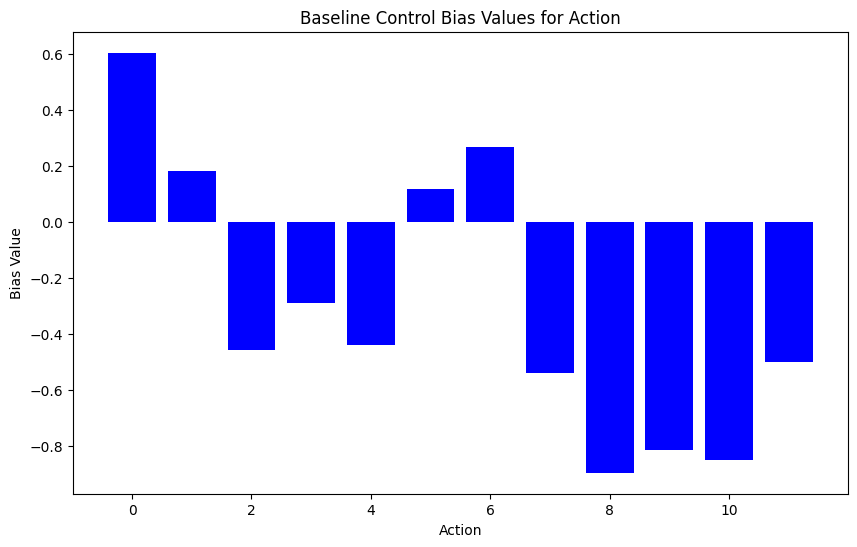

In [ ]:
#Plot biases for each action
plt.figure(figsize=(10, 6))
plt.bar(range(len(Cont_biases)), Cont_biases, color='blue')
plt.xlabel('Action')
plt.ylabel('Bias Value')
plt.title('Baseline Control Bias Values for Action')
plt.show()

####Precision and Recall

In [ ]:
#Get predictions
glm_predictions = glm_model.predict(Cont_X_val)
glm_pred_classes = np.argmax(glm_predictions, axis=1)  # Get class with highest probability

#Flatten true labels (they should already be 1D for sparse categorical)
true_labels = Cont_y_val.flatten()

#Calculate precision and recall for each class
precision = precision_score(true_labels, glm_pred_classes, average=None)
recall = recall_score(true_labels, glm_pred_classes, average=None)

print("Precision for each class (action):", precision)
print("Recall for each class (action):", recall)

1232/1232 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Precision for each class (action): [0.71165749 0.61041667 0.27016129 0.29978587 0.29064039 0.59152162
 0.58065247 0.59539171 0.22727273 0.29390681 0.22164948 0.46196404]
Recall for each class (action): [0.91922589 0.58560959 0.06627102 0.155902   0.05750487 0.53887468
 0.52040609 0.45525018 0.00998004 0.11096076 0.09267241 0.34081633]


####Confusion Matrix

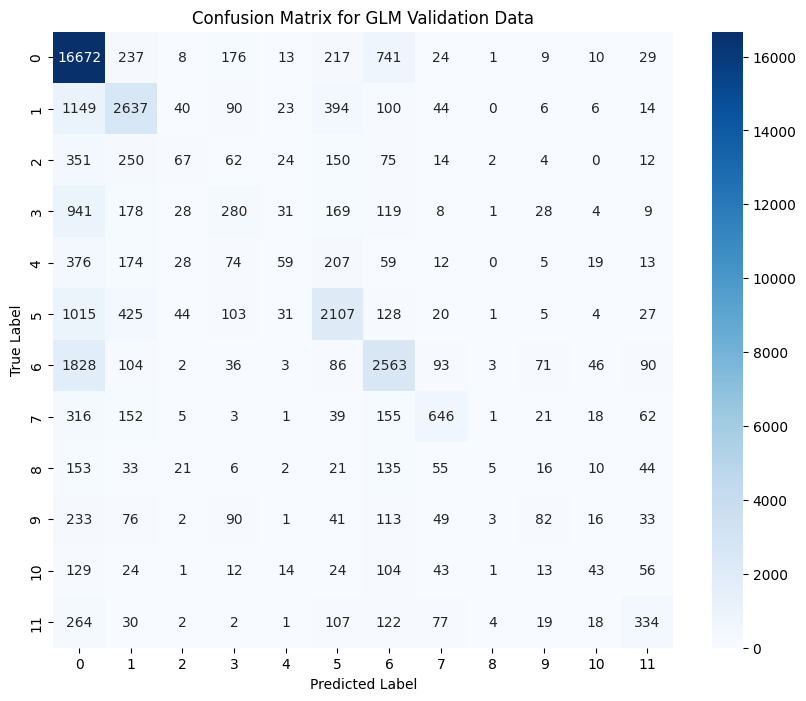

In [ ]:
#Create confusion matrix
conf_matrix = confusion_matrix(true_labels, glm_pred_classes)

#Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(num_actions), yticklabels=range(num_actions))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for GLM Validation Data')
plt.show()

###iii) Parameter Search

parameter seearch for unit sizes and learning rate using Optuna

In [ ]:
# import optuna

# # Define the number of unique actions for the output layer size
# num_actions = len(np.unique(Cont_y))

# # Define the objective function for Optuna
# def objective(trial):
#     # Suggest values for the number of units in the Dense layer and learning rate
#     units = trial.suggest_int("units", 12, 128, step=4)  # From 8 to 128 with steps of 4
#     learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-1)

#     # Build the model with the suggested hyperparameters
#     model = Sequential([
#         Dense(units, input_shape=(85,), activation='softmax')
#     ])

#     # Define the optimizer with the suggested learning rate
#     optimizer = Adam(learning_rate=learning_rate)

#     # Compile the model
#     model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#     # Early stopping to avoid overfitting
#     early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

#     # Fit the model on the training data
#     history = model.fit(
#         Cont_X_train, Cont_y_train,
#         epochs=50,
#         validation_data=(Cont_X_val, Cont_y_val),
#         batch_size=32,
#         callbacks=[early_stopping],
#         verbose=0  # Suppress training output for faster Optuna search
#     )

#     # Retrieve the best validation accuracy from training
#     val_accuracy = max(history.history['val_accuracy'])

#     # Return the validation accuracy as the objective value
#     return val_accuracy

# # Create the Optuna study and optimize the objective function
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=60)  # Run 50 trials

# # Print the best hyperparameters and the best accuracy
# print("Best hyperparameters:", study.best_params)
# print("Best validation accuracy:", study.best_value)


##c) Additional Negative Control Models


2) Generate Predictions: Use this function to create predictions for all entries in the validation set.

3) Calculate Accuracy: Compare these constant predictions with the actual targets from the validation set (y_val) to get the accuracy.

4) add one dense hidden layer and compare to dense with no hidden layers

###i) random prediction model

Function to Create Constant Predictions: create_constant_predictions(size, constant_value) generates an array where each value is a constant (e.g., 6).

Randomly assign one of the 370 unique board states for each action as a control. This would test whether model does better than random guessing of board states.

In [ ]:
# Possible actions
unique_actions = np.unique(Cont_y_train)

# Generate random predictions for the training set
random_predictions_train = np.random.choice(unique_actions, size=len(Cont_y_train))

# Generate random predictions for the validation set
random_predictions_val = np.random.choice(unique_actions, size=len(Cont_y_val))

# Evaluate the random prediction model's accuracy
train_accuracy = (random_predictions_train == Cont_y_train).mean()
val_accuracy = (random_predictions_val == Cont_y_val).mean()
print(f"Random Prediction Model Training Accuracy: {train_accuracy:.4f}")
print(f"Random Prediction Model Validation Accuracy: {val_accuracy:.4f}")


Random Prediction Model Training Accuracy: 0.0827
Random Prediction Model Validation Accuracy: 0.0818


###ii) predicting static action

Generate Static Predictions: This function to creates results of static predictions for all entries in the validation set. This will ensure model isnt just guessing most common action.

Combined Accuracies for Static Predictions:
Accuracy if always predicting action 0: 0.4746
Accuracy if always predicting action 1: 0.1162
Accuracy if always predicting action 2: 0.0263
Accuracy if always predicting action 3: 0.0478
Accuracy if always predicting action 4: 0.0272
Accuracy if always predicting action 5: 0.0963
Accuracy if always predicting action 6: 0.1249
Accuracy if always predicting action 7: 0.0270
Accuracy if always predicting action 8: 0.0103
Accuracy if always predicting action 9: 0.0165
Accuracy if always predicting action 10: 0.0102
Accuracy if always predicting action 11: 0.0227


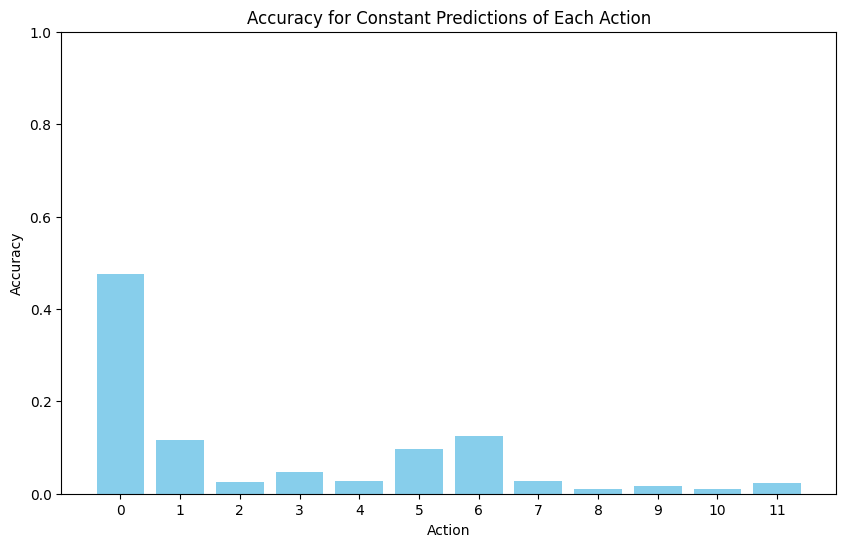

In [ ]:
# Combining training and validation labels
Cont_y_combined = np.concatenate((Cont_y_train, Cont_y_val))

#number of unique actions
num_actions = 12

# Initialize a dictionary to store accuracy for each action
action_accuracy_combined = {}

# Loop over each action (0 to num_actions-1)
for action in range(num_actions):
    # Create a constant array of predictions, all set to the current action
    constant_prediction_combined = np.full_like(Cont_y_combined, action)

    # Calculate accuracy for this constant prediction
    acc_combined = accuracy_score(Cont_y_combined, constant_prediction_combined)

    # Store the result
    action_accuracy_combined[action] = acc_combined

# Printing the accuracies for each action
print("Combined Accuracies for Static Predictions:")
for action, acc in action_accuracy_combined.items():
    print(f'Accuracy if always predicting action {action}: {acc:.4f}')

# plot the accuracies for combined dataset
plt.figure(figsize=(10, 6))
plt.bar(action_accuracy_combined.keys(), action_accuracy_combined.values(), color='skyblue')
plt.xlabel('Action')
plt.ylabel('Accuracy')
plt.title('Accuracy for Constant Predictions of Each Action')
plt.xticks(range(num_actions))
plt.ylim(0, 1)
plt.show()


###iii) GLM which predicts using only the previous action (last 13 values of gamestate)

Shape of Cont_X_train_last13: (164038, 13)
Shape of Cont_X_val_last13: (39411, 13)
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5127/5127 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.1761 - loss: 2.3024 - val_accuracy: 0.4601 - val_loss: 1.8628
Epoch 2/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.4823 - loss: 1.7468 - val_accuracy: 0.5590 - val_loss: 1.5840
Epoch 3/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.5690 - loss: 1.5154 - val_accuracy: 0.5601 - val_loss: 1.4928
Epoch 4/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.5697 - loss: 1.4483 - val_accuracy: 0.5800 - val_loss: 1.4549
Epoch 5/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5876 - loss: 1.4070 - val_accuracy: 0.5815 - val_loss: 1.4363
Epoch 6/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.5867 - loss: 1.4012 - val_accuracy: 0.5892 - val_loss: 1.4255
Epoch 7/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.5946 - loss: 1.3945 - val_accuracy: 0.5923 - val_loss: 1.4186
Epoch 8/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.5961 - loss: 1.3893 - val

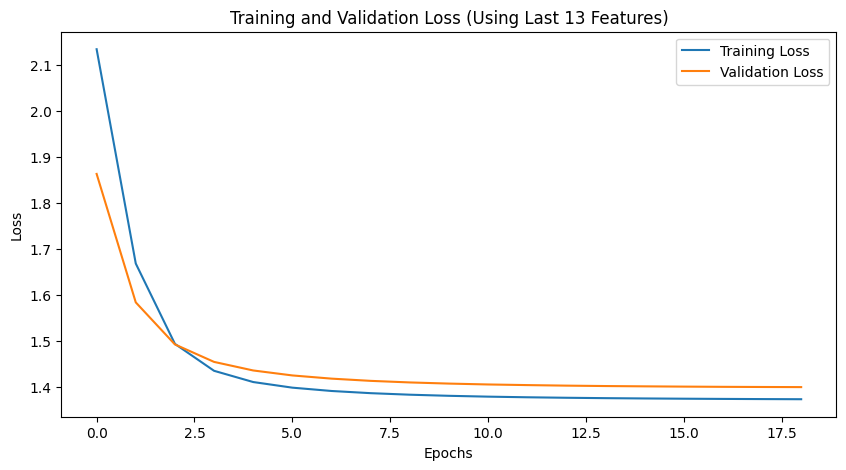

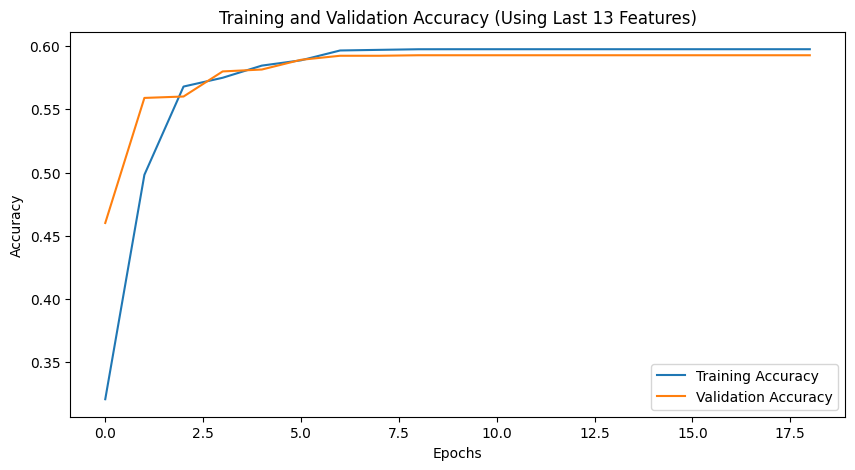

In [ ]:
# Slice dataset to use only the last 13 elements of board states for training
Cont_X_train_last13 = Cont_X_train[:, -13:]
Cont_X_val_last13 = Cont_X_val[:, -13:]

# Check the shapes
print("Shape of Cont_X_train_last13:", Cont_X_train_last13.shape)
print("Shape of Cont_X_val_last13:", Cont_X_val_last13.shape)

# Build the GLM model
control_model = Sequential([
    Dense(num_actions, input_shape=(13,), activation='softmax')  #Same number of actions as before (12)
])

# Defining the optimizer with a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compiling the model
control_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Add early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Fitting the model with early stopping
control1_history = control_model.fit(
    Cont_X_train_last13, Cont_y_train,
    epochs=50,
    validation_data=(Cont_X_val_last13, Cont_y_val),
    batch_size=32,
    callbacks=[early_stopping]
)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(control1_history.history['loss'], label='Training Loss')
plt.plot(control1_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Using Last 13 Features)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(control1_history.history['accuracy'], label='Training Accuracy')
plt.plot(control1_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Using Last 13 Features)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
Cont_val_loss, Cont_val_acc = control_model.evaluate(Cont_X_val_last13, Cont_y_val)
print(f'Validation Loss: {Cont_val_loss}')
print(f'Validation Accuracy: {Cont_val_acc}')

1232/1232 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6073 - loss: 1.3624
Validation Loss: 1.4103286266326904
Validation Accuracy: 0.5927532911300659


###iv) GLM which predicts using only the board state (first 72 values of gamestate)

Epoch 1/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.3897 - loss: 2.2622 - val_accuracy: 0.4806 - val_loss: 1.8667
Epoch 2/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5008 - loss: 1.7562 - val_accuracy: 0.5166 - val_loss: 1.6098
Epoch 3/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.5342 - loss: 1.5417 - val_accuracy: 0.5481 - val_loss: 1.5188
Epoch 4/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.5662 - loss: 1.4678 - val_accuracy: 0.5722 - val_loss: 1.4772
Epoch 5/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.5819 - loss: 1.4299 - val_accuracy: 0.5731 - val_loss: 1.4542
Epoch 6/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5826 - loss: 1.4135 - val_accuracy: 0.5767 - val_loss: 1.4401
Epoch 7/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.5886 - loss: 1.3965 - val_accuracy: 0.5770 - val_loss: 1.4309
Epoch 8/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.5888 - loss: 1

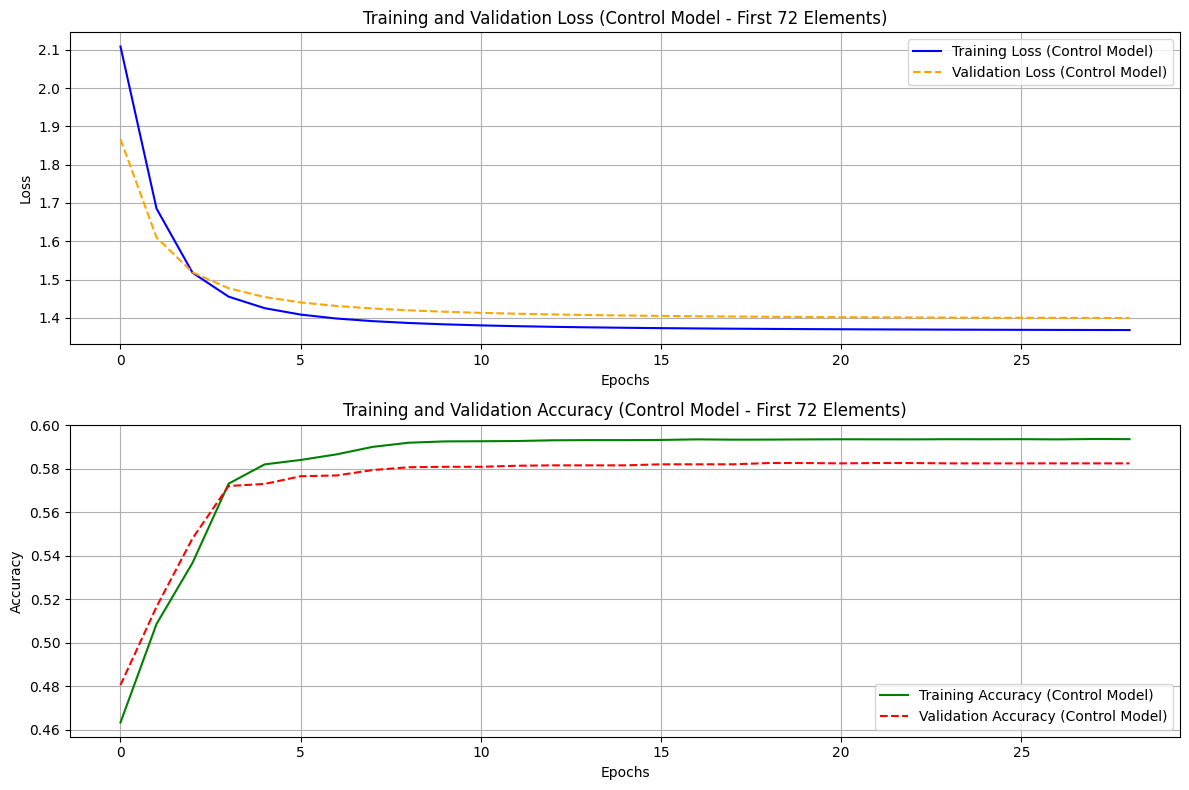

In [ ]:
# Slice to use only the last 13 elements of board states for training
Cont_X_train_first72 = Cont_X_train[:, :72]
Cont_X_val_first72 = Cont_X_val[:, :72]

# Build the control model with adjusted input shape
control_model2 = Sequential([
    Dense(num_actions, input_shape=(72,), activation='softmax')
])

# Defining the optimizer with a custom learning rate
optimizer_control = tf.keras.optimizers.Adam(learning_rate=0.0001)

# compliling control model
control_model2.compile(optimizer=optimizer_control, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Add early stopping callback
early_stopping_control = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Fit the control model with early stopping
history_control2 = control_model2.fit(
    Cont_X_train_first72, Cont_y_train,
    epochs=50,
    validation_data=(Cont_X_val_first72, Cont_y_val),
    batch_size=32,
    callbacks=[early_stopping_control]
)
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 8))

# Plot training and validation loss
plt.subplot(2, 1, 1)
plt.plot(history_control2.history['loss'], label='Training Loss (Control Model)', color='blue')
plt.plot(history_control2.history['val_loss'], label='Validation Loss (Control Model)', color='orange', linestyle='--')
plt.title('Training and Validation Loss (Control Model - First 72 Elements)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot training and validation Accuracy
plt.subplot(2, 1, 2)
plt.plot(history_control2.history['accuracy'], label='Training Accuracy (Control Model)', color='green')
plt.plot(history_control2.history['val_accuracy'], label='Validation Accuracy (Control Model)', color='red', linestyle='--')
plt.title('Training and Validation Accuracy (Control Model - First 72 Elements)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
Cont_val_loss, Cont_val_acc = control_model2.evaluate(Cont_X_val_first72, Cont_y_val)
print(f'Validation Loss: {Cont_val_loss}')
print(f'Validation Accuracy: {Cont_val_acc}')

1232/1232 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6112 - loss: 1.3264
Validation Loss: 1.402648687362671
Validation Accuracy: 0.5827307105064392


###v) Isolating role of Non-linearity: Dense network with one hidden dense layer

In [ ]:
# Determine the number of unique actions for the output layer size
num_actions = 12#len(np.unique(Cont_y))

# Build the model with an additional hidden layer
control_model3 = Sequential([
    Dense(64, input_shape=(85,), activation='relu'),  # Hidden layer with ReLU activation
    Dense(num_actions, activation='softmax')          # Output layer for classification
])

# Defining the optimizer with our custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compiling model
control_model3.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Adding early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Fitting the model with early stopping
history_control3 = control_model3.fit(
    Cont_X_train, Cont_y_train,
    epochs=50,
    validation_data=(Cont_X_val, Cont_y_val),
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.5116 - loss: 1.7148 - val_accuracy: 0.6369 - val_loss: 1.2765
Epoch 2/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.6433 - loss: 1.2372 - val_accuracy: 0.6440 - val_loss: 1.2327
Epoch 3/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6477 - loss: 1.2085 - val_accuracy: 0.6462 - val_loss: 1.2198
Epoch 4/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6507 - loss: 1.1930 - val_accuracy: 0.6473 - val_loss: 1.2144
Epoch 5/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6509 - loss: 1.1900 - val_accuracy: 0.6474 - val_loss: 1.2101
Epoch 6/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.6509 - loss: 1.1885 - val_accuracy: 0.6473 - val_loss: 1.2076
Epoch 7/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.6529 - loss: 1.1770 - val_accuracy: 0.6480 - val_loss: 1.2050
Epoch 8/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6511 - loss: 1

In [ ]:
val_loss, val_accuracy = control_model3.evaluate(Cont_X_val, Cont_y_val, verbose=1)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

1232/1232 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6636 - loss: 1.1524
Validation Loss: 1.1944245100021362
Validation Accuracy: 0.6497170925140381


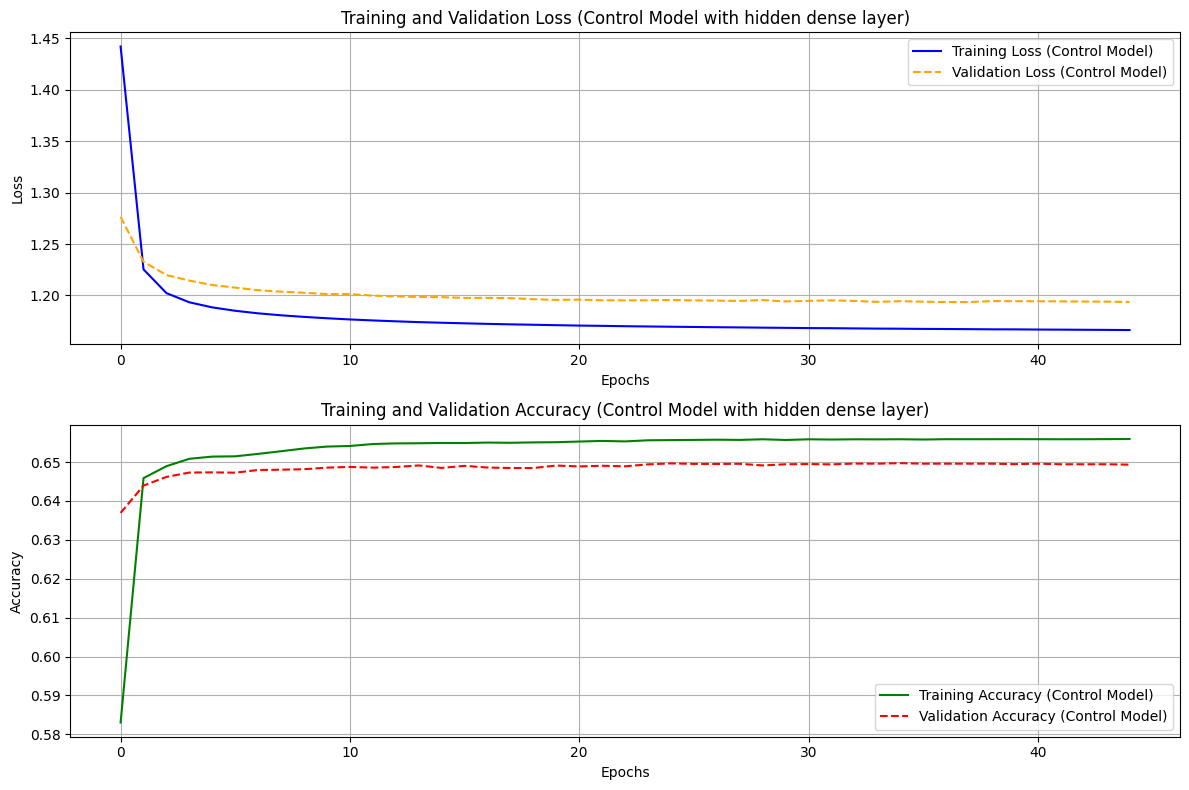

In [ ]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 8))

# Plot for Loss
plt.subplot(2, 1, 1)
plt.plot(history_control3.history['loss'], label='Training Loss (Control Model)', color='blue')
plt.plot(history_control3.history['val_loss'], label='Validation Loss (Control Model)', color='orange', linestyle='--')
plt.title('Training and Validation Loss (Control Model with hidden dense layer)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot for Accuracy
plt.subplot(2, 1, 2)
plt.plot(history_control3.history['accuracy'], label='Training Accuracy (Control Model)', color='green')
plt.plot(history_control3.history['val_accuracy'], label='Validation Accuracy (Control Model)', color='red', linestyle='--')
plt.title('Training and Validation Accuracy (Control Model with hidden dense layer)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


####Precision and Recall

In [ ]:
#Get model predictions
y_pred_proba = control_model3.predict(Cont_X_val)  # Predictions in probability format
y_pred = np.argmax(y_pred_proba, axis=1)  # Convert to class labels

#Calculate precision and recall for each class
precision = precision_score(Cont_y_val, y_pred, average=None)  # Precision per class
recall = recall_score(Cont_y_val, y_pred, average=None)        # Recall per class

print("Precision for each class (action):", precision)
print("Recall for each class (action):", recall)

1232/1232 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Precision for each class (action): [0.70836684 0.6392234  0.2815534  0.3010989  0.29927007 0.60433914
 0.57711111 0.62536873 0.15555556 0.29109589 0.31851852 0.46565934]
Recall for each class (action): [0.92286486 0.57761492 0.08605341 0.15256125 0.07992203 0.54143223
 0.52730964 0.44820296 0.01397206 0.1150203  0.09267241 0.34591837]


####Confusion matrix

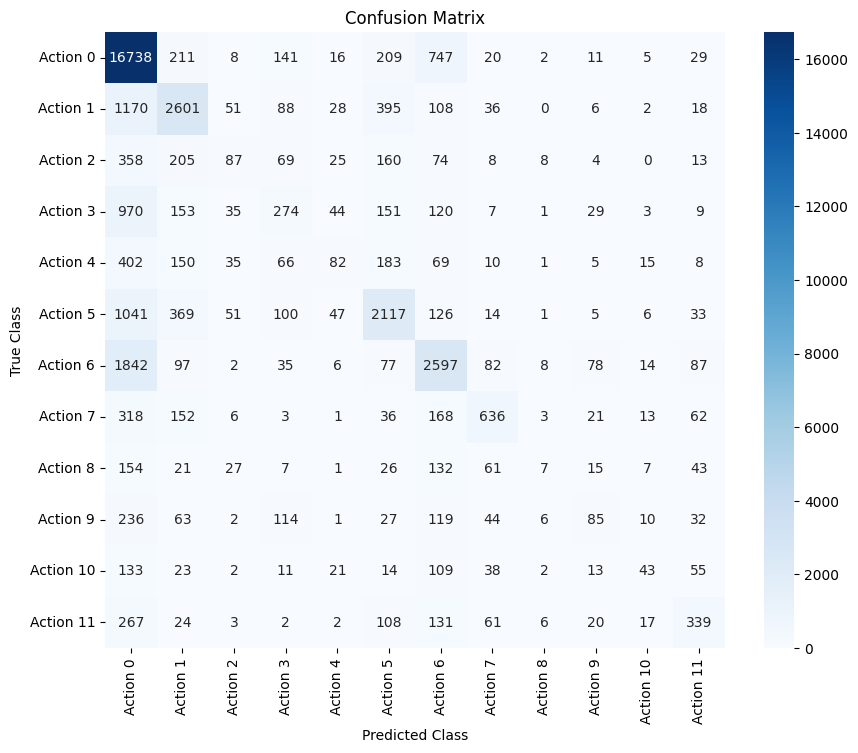

In [ ]:
#Generate confusion matrix
cm = confusion_matrix(Cont_y_val, y_pred)

# Plotting the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Action {i}' for i in range(num_actions)],
            yticklabels=[f'Action {i}' for i in range(num_actions)])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

####Visualize Biases

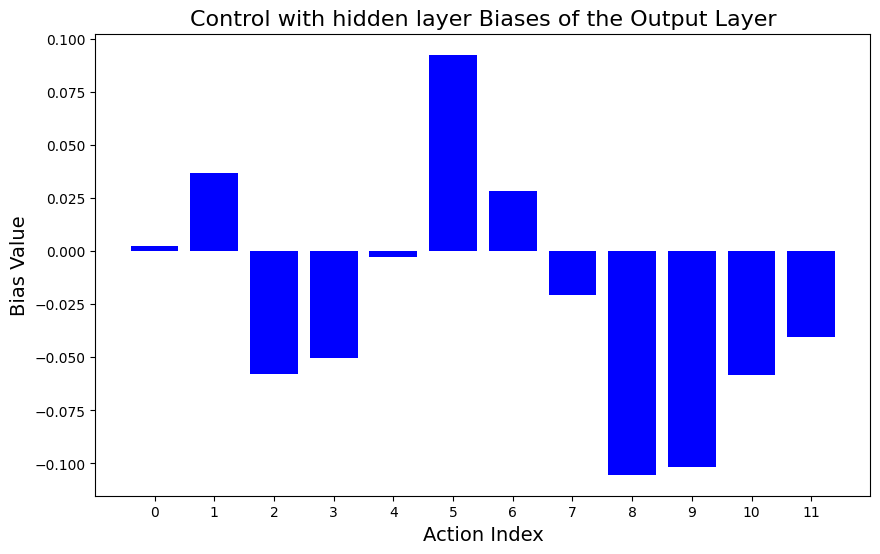

In [ ]:
# Access the Dense layer (output layer)
output_layer = control_model3.layers[-1]  # Last layer in the model

# Extract the biases (second element of the weights list)
biases = output_layer.get_weights()[1]

# Visualize the biases
plt.figure(figsize=(10, 6))
plt.bar(range(len(biases)), biases, color='blue')
plt.xlabel('Action Index', fontsize=14)
plt.ylabel('Bias Value', fontsize=14)
plt.title('Control with hidden layer Biases of the Output Layer', fontsize=16)
plt.xticks(range(len(biases)), labels=np.arange(len(biases)))
plt.show()

####Previous Action only (last 13 values)

In [ ]:
# Determine the number of unique actions for the output layer size
num_actions = 12#len(np.unique(Cont_y))

# Build the model with an additional hidden layer
control_model3_13 = Sequential([
    Dense(64, input_shape=(13,), activation='relu'),  # Hidden layer with ReLU activation
    Dense(num_actions, activation='softmax')          # Output layer for classification
])

# Define the optimizer with a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model
control_model3_13.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Add early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Fit the model with early stopping
history_control3_13 = control_model3_13.fit(
    Cont_X_train_last13, Cont_y_train,
    epochs=50,
    validation_data=(Cont_X_val_last13, Cont_y_val),
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5127/5127 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.4687 - loss: 1.8681 - val_accuracy: 0.5911 - val_loss: 1.4270
Epoch 2/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.5959 - loss: 1.3937 - val_accuracy: 0.5928 - val_loss: 1.4060
Epoch 3/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5988 - loss: 1.3773 - val_accuracy: 0.5928 - val_loss: 1.4023
Epoch 4/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.5996 - loss: 1.3716 - val_accuracy: 0.5928 - val_loss: 1.4005
Epoch 5/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.5976 - loss: 1.3739 - val_accuracy: 0.5928 - val_loss: 1.4000
Epoch 6/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.5985 - loss: 1.3693 - val_accuracy: 0.5933 - val_loss: 1.3992
Epoch 7/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.5980 - loss: 1.3725 - val_accuracy: 0.5933 - val_loss: 1.3989
Epoch 8/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.5957 - loss: 1.3786 - val

In [ ]:
val_loss, val_accuracy = control_model3_13.evaluate(Cont_X_val_last13, Cont_y_val, verbose=1)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


1232/1232 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6075 - loss: 1.3557
Validation Loss: 1.3991708755493164
Validation Accuracy: 0.5932861566543579


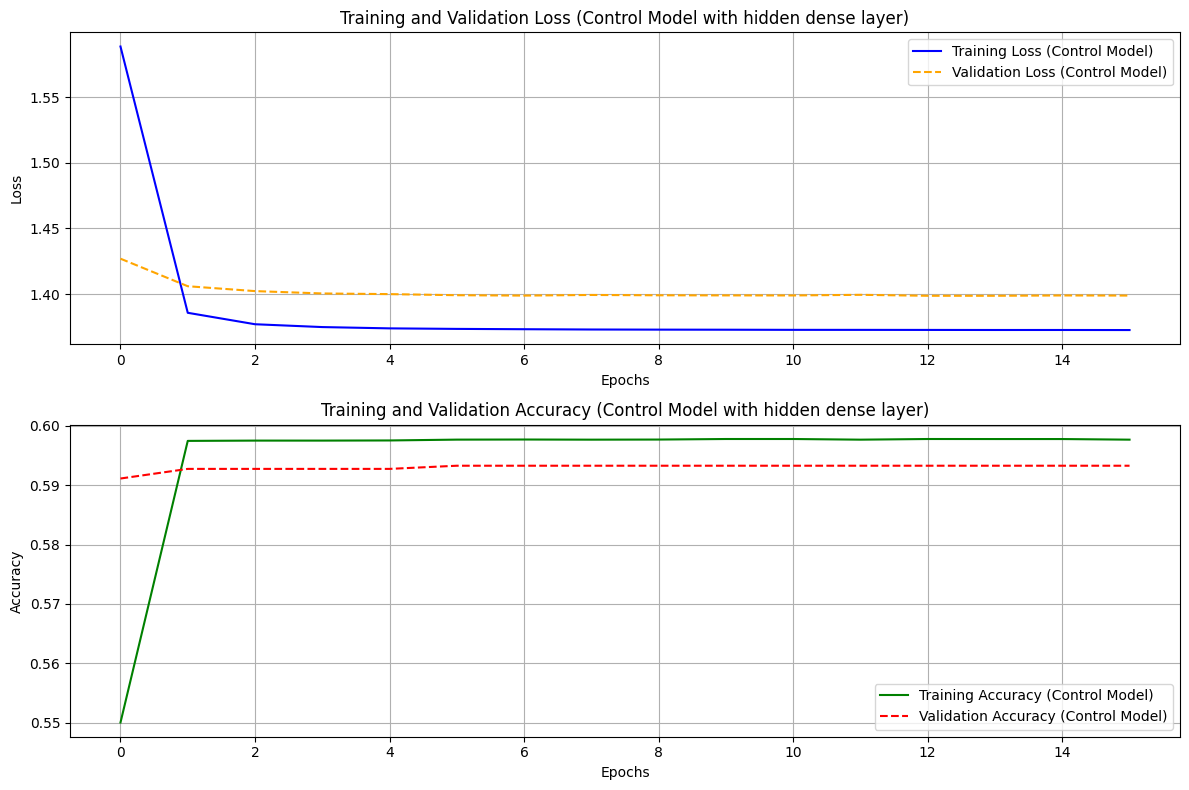

In [ ]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 8))

# Plot for Loss
plt.subplot(2, 1, 1)
plt.plot(history_control3_13.history['loss'], label='Training Loss (Control Model)', color='blue')
plt.plot(history_control3_13.history['val_loss'], label='Validation Loss (Control Model)', color='orange', linestyle='--')
plt.title('Training and Validation Loss (Control Model with hidden dense layer)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot for Accuracy
plt.subplot(2, 1, 2)
plt.plot(history_control3_13.history['accuracy'], label='Training Accuracy (Control Model)', color='green')
plt.plot(history_control3_13.history['val_accuracy'], label='Validation Accuracy (Control Model)', color='red', linestyle='--')
plt.title('Training and Validation Accuracy (Control Model with hidden dense layer)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


####Board state only (First 72 values)

In [ ]:
# Determine the number of unique actions for the output layer size
num_actions = 12#len(np.unique(Cont_y))

control_model3_72 = Sequential([
    Dense(64, input_shape=(72,), activation='relu'),
    Dense(num_actions, activation='softmax')
])

# Define the optimizer with our custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compiling the model
control_model3_72.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Adding early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Fitting the model with early stopping
history_control3_72 = control_model3_72.fit(
    Cont_X_train_first72, Cont_y_train,
    epochs=50,
    validation_data=(Cont_X_val_first72, Cont_y_val),
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.4562 - loss: 1.8762 - val_accuracy: 0.5757 - val_loss: 1.4518
Epoch 2/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.5878 - loss: 1.4049 - val_accuracy: 0.5818 - val_loss: 1.4198
Epoch 3/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.5936 - loss: 1.3844 - val_accuracy: 0.5820 - val_loss: 1.4103
Epoch 4/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.5951 - loss: 1.3746 - val_accuracy: 0.5826 - val_loss: 1.4057
Epoch 5/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.5945 - loss: 1.3710 - val_accuracy: 0.5826 - val_loss: 1.4030
Epoch 6/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.5924 - loss: 1.3685 - val_accuracy: 0.5825 - val_loss: 1.4008
Epoch 7/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.5973 - loss: 1.3605 - val_accuracy: 0.5825 - val_loss: 1.4006
Epoch 8/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.5936 - loss: 1

In [ ]:
val_loss, val_accuracy = control_model3_72.evaluate(Cont_X_val_first72, Cont_y_val, verbose=1)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


1232/1232 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6113 - loss: 1.3281
Validation Loss: 1.4056763648986816
Validation Accuracy: 0.5826038122177124


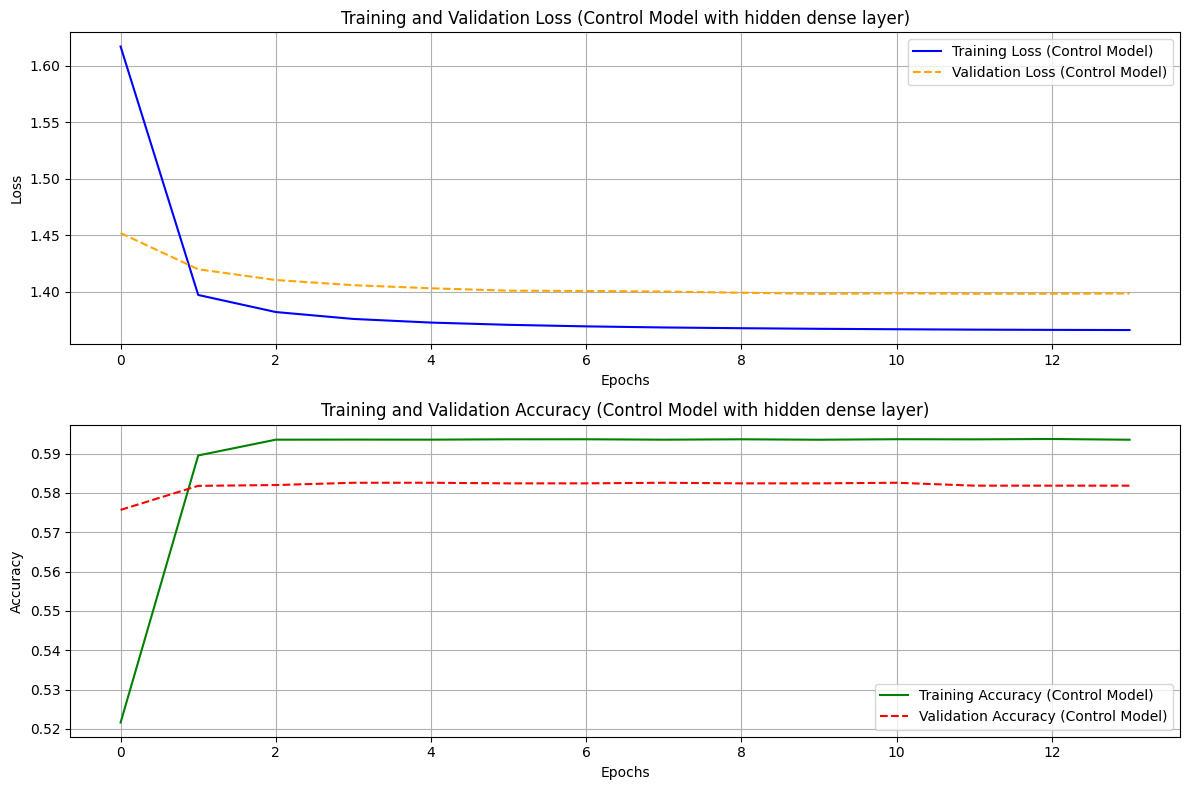

In [ ]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 8))

# Plot for Loss
plt.subplot(2, 1, 1)
plt.plot(history_control3_72.history['loss'], label='Training Loss (Control Model)', color='blue')
plt.plot(history_control3_72.history['val_loss'], label='Validation Loss (Control Model)', color='orange', linestyle='--')
plt.title('Training and Validation Loss (Control Model with hidden dense layer)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot for Accuracy
plt.subplot(2, 1, 2)
plt.plot(history_control3_72.history['accuracy'], label='Training Accuracy (Control Model)', color='green')
plt.plot(history_control3_72.history['val_accuracy'], label='Validation Accuracy (Control Model)', color='red', linestyle='--')
plt.title('Training and Validation Accuracy (Control Model with hidden dense layer)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Adjust layout and display
plt.tight_layout()
plt.show()


##d) Comparing controls

Additional comparison ahead in section 3) model comparison

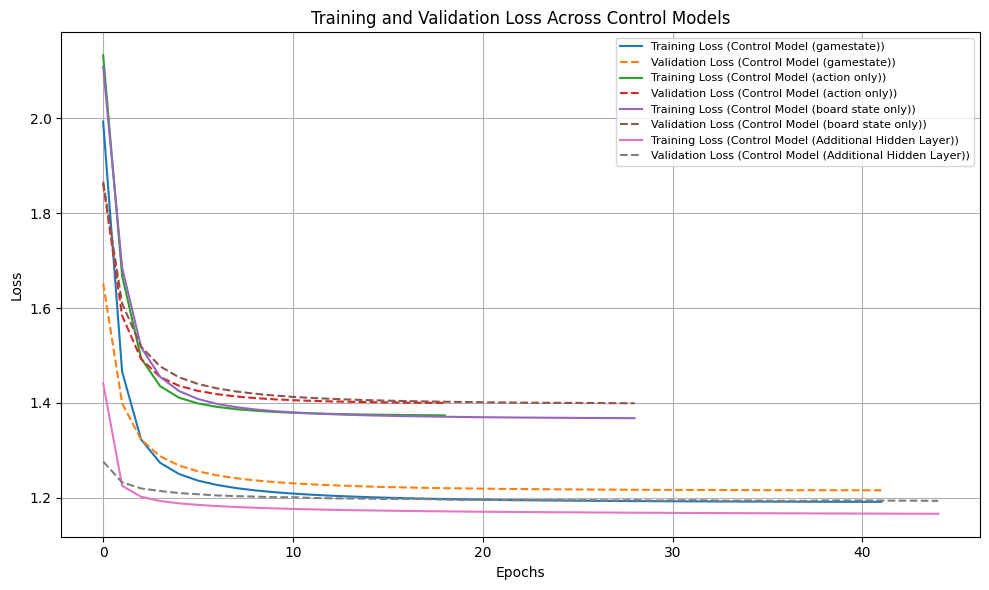

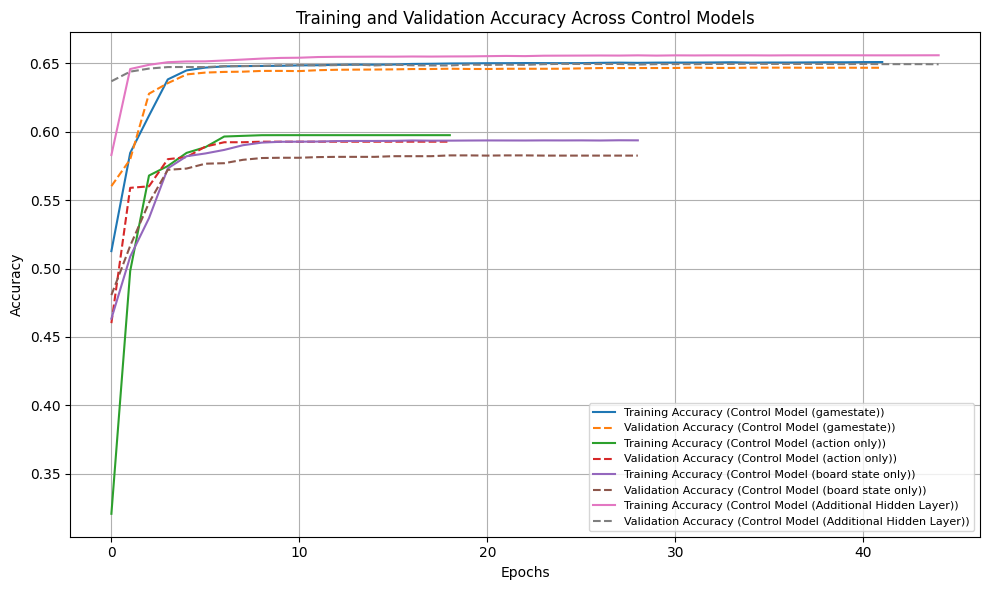

In [ ]:
# Step 1: Retrieve histories for all models
histories = {
    "Control Model (gamestate)": glm_history.history,
    "Control Model (action only)": control1_history.history,
    "Control Model (board state only)": history_control2.history,
    "Control Model (Additional Hidden Layer)": history_control3.history,
}

# Step 2: Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
for model_name, history in histories.items():
    plt.plot(history['loss'], label=f'Training Loss ({model_name})')
    plt.plot(history['val_loss'], linestyle='--', label=f'Validation Loss ({model_name})')
plt.title('Training and Validation Loss Across Control Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize=8)  # Make the legend smaller
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 3: Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
for model_name, history in histories.items():
    plt.plot(history['accuracy'], label=f'Training Accuracy ({model_name})')
    plt.plot(history['val_accuracy'], linestyle='--', label=f'Validation Accuracy ({model_name})')
plt.title('Training and Validation Accuracy Across Control Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(fontsize=8)  # Make the legend smaller
plt.grid(True)
plt.tight_layout()
plt.show()
